In [1]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import networkx as nx

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv, APPNP
from torch_geometric.data import Data

from dataclasses import dataclass

from inductive_bench import InductiveExperiment


In [2]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seeds(42)

In [3]:
root = './data'
dataset = Planetoid(root=root, name='Cora')
data = dataset[0].to((DEVICE))

## 1. Exploratory Data Analysis

### Construct the DataFrame

To make the EDA clearer, we decided to work with the raw Cora data (downloaded directly, without any additional encoding).

In [4]:
data_dir = "data/cora-raw"
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep="\t", header=None, names=["target", "source"])
edgelist["label"]="cites"

In [5]:
edgelist.sample(frac=1).head()

,target,source,label
79,35,263498,cites
3161,45605,503871,cites
1643,9581,1130780,cites
167,40,1114442,cites
439,1365,22835,cites


In [6]:
edgelist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5429 non-null   int64 
 1   source  5429 non-null   int64 
 2   label   5429 non-null   object
dtypes: int64(2), object(1)
memory usage: 127.4+ KB


In [7]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

In [8]:
node_data.head(5)

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


We use `node_data` for the node features and `edgelist` for the graph’s edges.

---

### Basic Info

In [9]:
print("Nodes:", len(node_data))
print("Edges:", len(edgelist))

print("\nNode dtypes:")
print(node_data.dtypes.head())

print("\nSubjects:")
print(node_data["subject"].value_counts())

Nodes: 2708
Edges: 5429

Node dtypes:
w_0    int64
w_1    int64
w_2    int64
w_3    int64
w_4    int64
dtype: object

Subjects:
subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


### Number of words per document

In [10]:
node_data['num_words'] = node_data[feature_names].sum(axis=1)

print(node_data['num_words'].describe())

count    2708.000000
mean       18.174298
std         5.758010
min         1.000000
25%        17.000000
50%        20.000000
75%        22.000000
max        30.000000
Name: num_words, dtype: float64


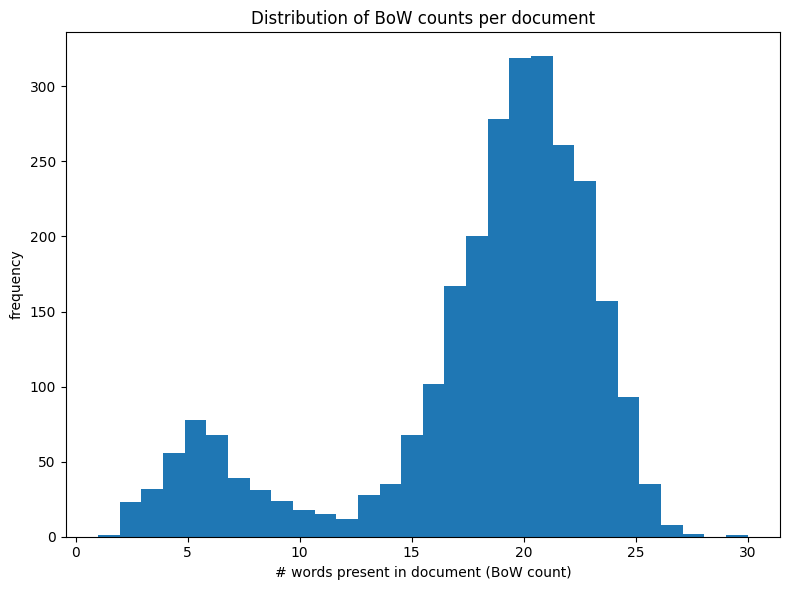

In [11]:
plt.figure(figsize=(8,6))
plt.hist(node_data['num_words'],bins=30)
plt.xlabel('# words present in document (BoW count)')
plt.ylabel('frequency')
plt.title("Distribution of BoW counts per document")
plt.tight_layout()
plt.show()

### Words per document by subject

In [12]:
group_stats = node_data.groupby("subject")["num_words"].describe()
print(group_stats)

                        count       mean       std  min   25%   50%   75%  \
subject                                                                     
Case_Based              298.0  18.620805  5.392397  2.0  18.0  20.0  22.0   
Genetic_Algorithms      418.0  17.660287  6.426071  2.0  16.0  20.0  22.0   
Neural_Networks         818.0  17.674817  5.919027  2.0  16.0  19.0  22.0   
Probabilistic_Methods   426.0  18.335681  6.011557  2.0  17.0  20.0  22.0   
Reinforcement_Learning  217.0  19.170507  5.088427  2.0  18.0  21.0  22.0   
Rule_Learning           180.0  18.988889  4.830061  2.0  18.0  20.0  22.0   
Theory                  351.0  18.341880  5.185963  1.0  17.0  20.0  21.0   

                         max  
subject                       
Case_Based              27.0  
Genetic_Algorithms      27.0  
Neural_Networks         27.0  
Probabilistic_Methods   30.0  
Reinforcement_Learning  26.0  
Rule_Learning           28.0  
Theory                  27.0  


<Figure size 800x600 with 0 Axes>

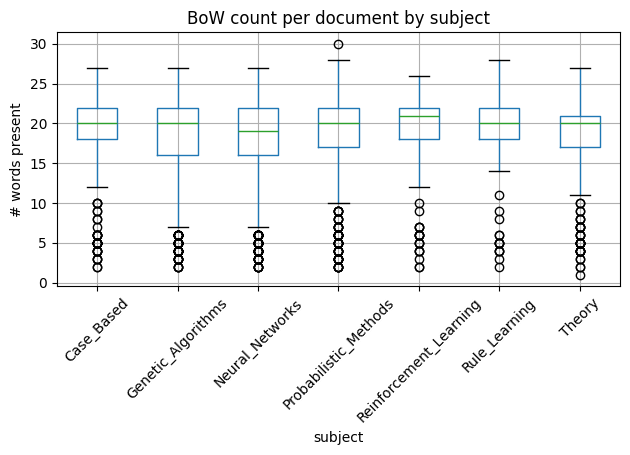

In [13]:
plt.figure(figsize=(8,6))
node_data.boxplot(column='num_words', by='subject', rot=45)
plt.ylabel('# words present')
plt.title('BoW count per document by subject')
plt.suptitle('')
plt.tight_layout()
plt.show()

### Global sparsity and word frequencies

#### Sparsity

In [14]:
X=node_data[feature_names].to_numpy()
print(X.shape)

(2708, 1433)


In [15]:
nnz = X.sum()
total = X.size
density = nnz / total

print(f'Non-zeros: {nnz}')
print(f'Total entries: {total}')
print(f'Density: {density:.6f}')
print(f'Sparsity: {1-density:.6f}')



Non-zeros: 49216
Total entries: 3880564
Density: 0.012683
Sparsity: 0.987317


#### Visualization of the sparsity

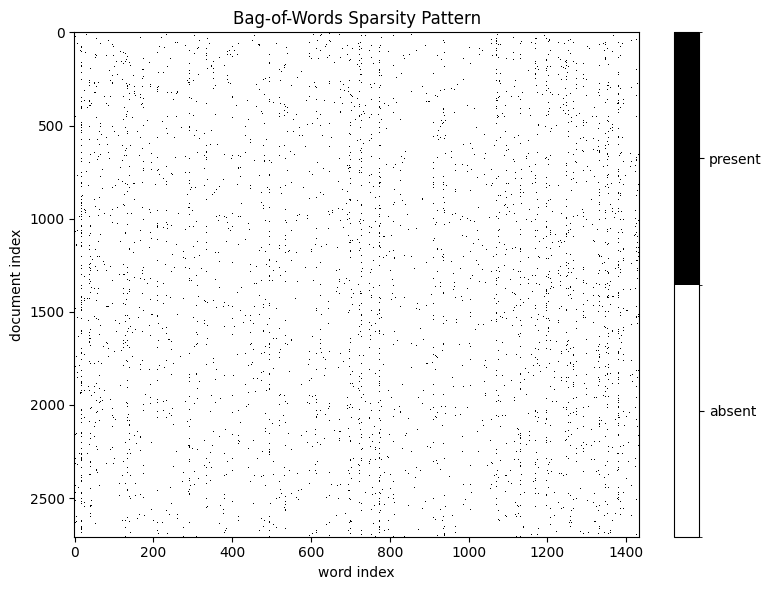

In [16]:
from matplotlib.colors import ListedColormap,  BoundaryNorm
cmap = ListedColormap(["white", "black"])
bounds = [-0.5, 0.5, 1.5] 
norm = BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(8, 6))
im = plt.imshow(X, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=[0, 1])
cbar.ax.set_yticklabels(["absent", "present"])  

plt.xlabel("word index")
plt.ylabel("document index")
plt.title("Bag-of-Words Sparsity Pattern")
plt.tight_layout()
plt.show()


Since we don't have the exactly what words in the bag-of-words, we don't perform the word frequency distribution.

### Graph structure from `edgelist`

#### Degree for each node

In [17]:
all_ends = pd.concat([edgelist['target'], edgelist['source']], axis=0)
degree_series = all_ends.value_counts().sort_index()

node_data['degree'] = degree_series.reindex(node_data.index).fillna(0).astype(int)

print(node_data["degree"].describe())

count    2708.000000
mean        4.009601
std         5.307457
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max       169.000000
Name: degree, dtype: float64


#### Degree distribution

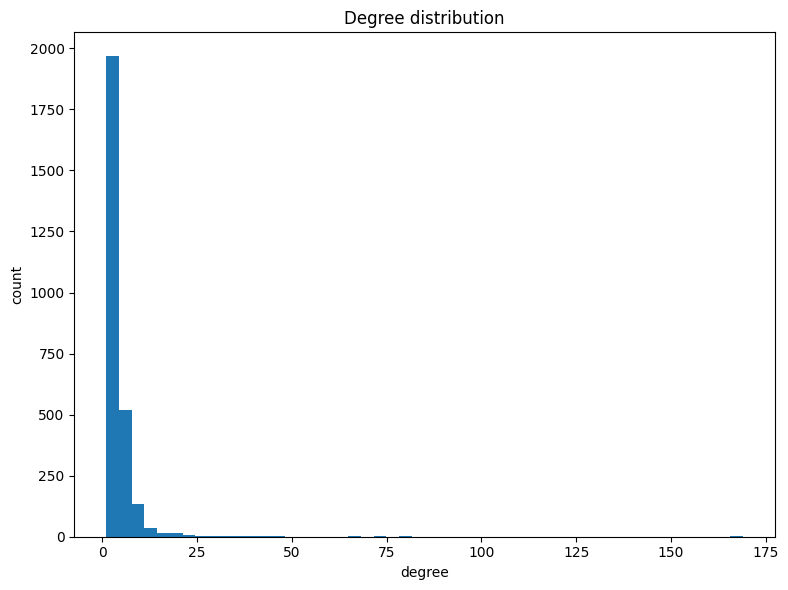

In [18]:
plt.figure(figsize=(8,6))
plt.hist(node_data['degree'], bins=50)
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Degree distribution')
plt.tight_layout()
plt.show()

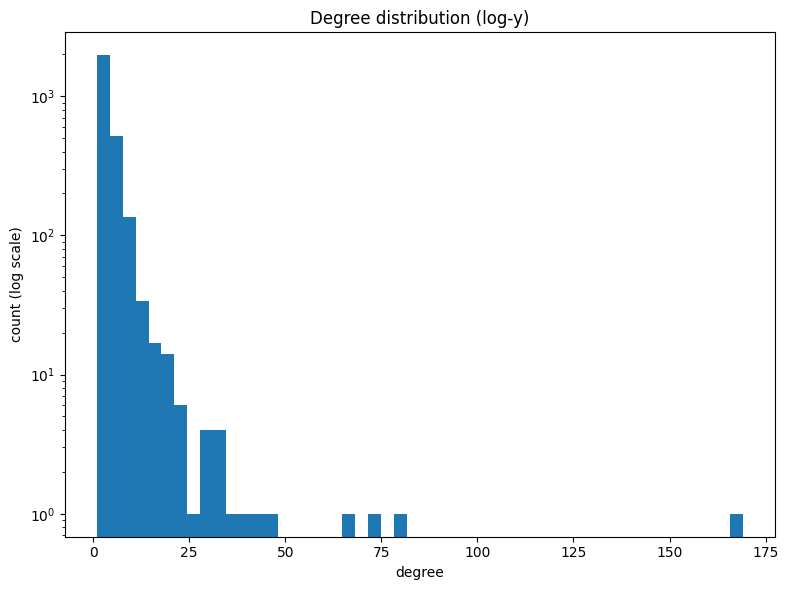

In [19]:
plt.figure(figsize=(8,6))
plt.hist(node_data['degree'], bins=50, log=True)
plt.xlabel('degree')
plt.ylabel('count (log scale)')
plt.title('Degree distribution (log-y)')
plt.tight_layout()
plt.show()

#### Degree vs subject

<Figure size 800x600 with 0 Axes>

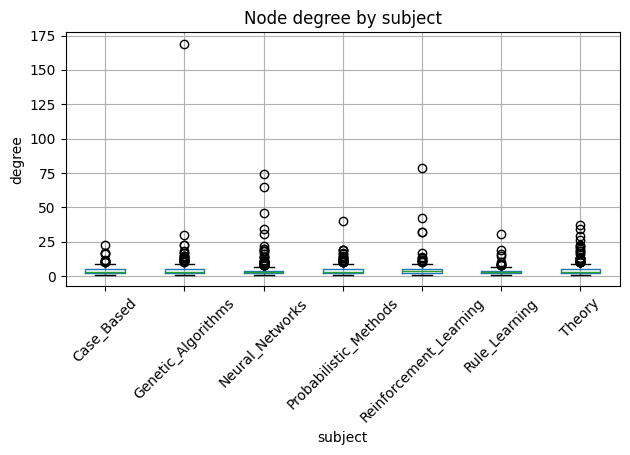

In [20]:
plt.figure(figsize=(8,6))
node_data.boxplot(column='degree', by='subject', rot=45)
plt.ylabel('degree')
plt.title('Node degree by subject')
plt.suptitle('')
plt.tight_layout()
plt.show()

### Label homophily on edges

How often do edges connect papers of the same subject?

In [21]:
labels = node_data['subject']

target_labels = labels.loc[edgelist['target']].to_numpy()
source_labels = labels.loc[edgelist['source']].to_numpy()

same_label = (target_labels == source_labels)
homophily = same_label.mean()

print(f"Fraction of edges with same subject: {homophily:.3f}")

Fraction of edges with same subject: 0.814


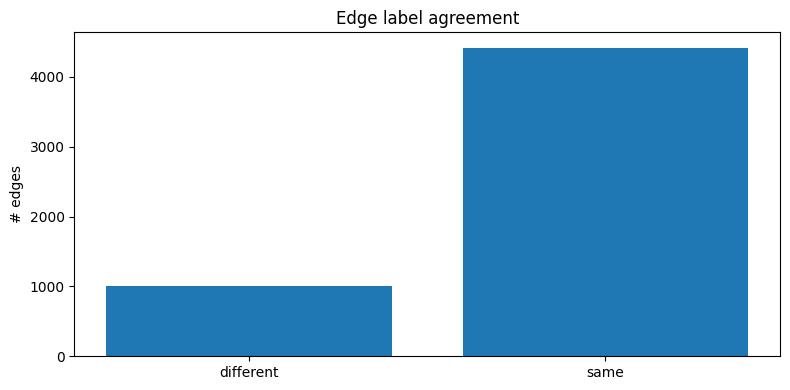

In [22]:
counts = np.bincount(same_label.astype(int))
plt.figure(figsize=(8,4))
plt.bar(['different', 'same'], counts)
plt.ylabel('# edges')
plt.title('Edge label agreement')
plt.tight_layout()
plt.show()

### Comnine BoW + graph info

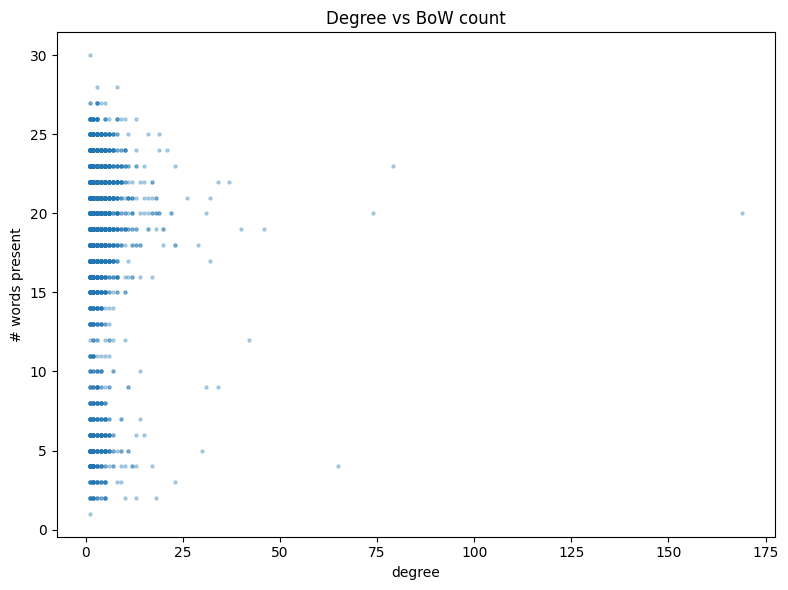

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(node_data['degree'], node_data['num_words'], alpha=0.3, s=5)
plt.xlabel('degree')
plt.ylabel('# words present')
plt.title('Degree vs BoW count')
plt.tight_layout()
plt.show()

## 2. Traditional Text Classification 

### a. Only using BoW feature

In [24]:
y = node_data["subject"]

all_nodes = node_data.index.to_numpy()

train_nodes, temp_nodes, y_train, y_temp = train_test_split(
    all_nodes,
    y,
    test_size=0.90,
    random_state=42,
    stratify=y
)

val_nodes, test_nodes, y_val, y_test = train_test_split(
    temp_nodes,
    y_temp,
    test_size=0.8890,           
    random_state=42,
    stratify=y_temp
)

print(len(train_nodes), len(val_nodes), len(test_nodes))

270 270 2168


#### Prepare features and labels

In [25]:
le = LabelEncoder()
y_encoded = le.fit_transform(node_data["subject"].values)
y_series = pd.Series(y_encoded, index = node_data.index)

In [26]:
def get_split(nodes):
    """
    Return X, y for the given list of node ids. 
    """
    X = node_data.loc[nodes, feature_names].values
    y = y_series.loc[nodes].values
    return X, y

X_train_raw, y_train = get_split(train_nodes)
X_val_raw,   y_val   = get_split(val_nodes)
X_test_raw,  y_test  = get_split(test_nodes)

print("Train shape:", X_train_raw.shape)
print("Val shape:  ", X_val_raw.shape)
print("Test shape: ", X_test_raw.shape)

Train shape: (270, 1433)
Val shape:   (270, 1433)
Test shape:  (2168, 1433)


Standardize features for models that need it (LogReg, MLP)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val   = scaler.transform(X_val_raw)
X_test  = scaler.transform(X_test_raw)

Simple tuning loop + evaluation for baseline

In [28]:
def evaluate_on_val_and_test(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"\n=== {name} ===")
    print(f"Val accuracy : {val_acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")
    print("Test classification report:")
    print(classification_report(y_test, test_pred, target_names=le.classes_))

    return val_acc, test_acc, model

#### Logistic Regression baseline

In [29]:
best_logreg = None
best_val_acc = -1.0
best_C = None

for C in [0.01, 0.1, 1.0, 10.0]:
    clf = LogisticRegression(
        C=C,
        max_iter=1000,
        n_jobs=-1,
        random_state=42,
    )
    val_acc, test_acc, _ = evaluate_on_val_and_test(
        name=f"LogisticRegression (C={C})",
        model=clf,
        X_train=X_train, y_train=y_train,
        X_val=X_val,     y_val=y_val,
        X_test=X_test,   y_test=y_test,
    )
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C

print(f"\nBest LogisticRegression C on val: {best_C} (val acc={best_val_acc:.4f})")


=== LogisticRegression (C=0.01) ===
Val accuracy : 0.5556
Test accuracy: 0.5706
Test classification report:
                        precision    recall  f1-score   support

            Case_Based       0.64      0.45      0.53       238
    Genetic_Algorithms       0.65      0.60      0.63       334
       Neural_Networks       0.49      0.90      0.64       655
 Probabilistic_Methods       0.75      0.46      0.57       342
Reinforcement_Learning       0.81      0.34      0.48       174
         Rule_Learning       0.91      0.15      0.25       144
                Theory       0.55      0.36      0.43       281

              accuracy                           0.57      2168
             macro avg       0.69      0.47      0.50      2168
          weighted avg       0.63      0.57      0.55      2168


=== LogisticRegression (C=0.1) ===
Val accuracy : 0.5667
Test accuracy: 0.5909
Test classification report:
                        precision    recall  f1-score   support

           

#### Random Forest baseline (uses raw features, no scaling needed)

In [30]:
best_rf = None
best_val_acc = -1.0
best_params_rf = None

for n_estimators in [100, 300]:
    for max_depth in [None, 10, 20]:
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=42,
        )
        val_acc, test_acc, _ = evaluate_on_val_and_test(
            name=f"RandomForest (n={n_estimators}, depth={max_depth})",
            model=rf,
            X_train=X_train_raw, y_train=y_train,   # raw features
            X_val=X_val_raw,     y_val=y_val,
            X_test=X_test_raw,   y_test=y_test,
        )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params_rf = (n_estimators, max_depth)

print(f"\nBest RandomForest params on val: n_estimators={best_params_rf[0]}, "
      f"max_depth={best_params_rf[1]} (val acc={best_val_acc:.4f})")



=== RandomForest (n=100, depth=None) ===
Val accuracy : 0.6111
Test accuracy: 0.6176
Test classification report:
                        precision    recall  f1-score   support

            Case_Based       0.55      0.45      0.50       238
    Genetic_Algorithms       0.88      0.72      0.79       334
       Neural_Networks       0.52      0.91      0.66       655
 Probabilistic_Methods       0.78      0.45      0.57       342
Reinforcement_Learning       0.89      0.55      0.68       174
         Rule_Learning       0.85      0.15      0.26       144
                Theory       0.55      0.44      0.49       281

              accuracy                           0.62      2168
             macro avg       0.72      0.52      0.56      2168
          weighted avg       0.68      0.62      0.60      2168


=== RandomForest (n=100, depth=10) ===
Val accuracy : 0.5296
Test accuracy: 0.5244
Test classification report:
                        precision    recall  f1-score   support

  

#### Simple MLP baseline

In [31]:
best_mlp = None
best_val_acc = -1.0
best_params_mlp = None

for hidden in [(64,), (128,), (128, 64)]:
    for alpha in [1e-4, 1e-3]:
        mlp = MLPClassifier(
            hidden_layer_sizes=hidden,
            activation="relu",
            alpha=alpha,
            batch_size=64,
            learning_rate_init=1e-3,
            max_iter=200,
            random_state=42,
        )
        val_acc, test_acc, _ = evaluate_on_val_and_test(
            name=f"MLP (hidden={hidden}, alpha={alpha})",
            model=mlp,
            X_train=X_train, y_train=y_train,
            X_val=X_val,     y_val=y_val,
            X_test=X_test,   y_test=y_test,
        )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params_mlp = (hidden, alpha)

print(f"\nBest MLP params on val: hidden={best_params_mlp[0]}, "
      f"alpha={best_params_mlp[1]} (val acc={best_val_acc:.4f})")


=== MLP (hidden=(64,), alpha=0.0001) ===
Val accuracy : 0.4815
Test accuracy: 0.5221
Test classification report:
                        precision    recall  f1-score   support

            Case_Based       0.46      0.53      0.50       238
    Genetic_Algorithms       0.46      0.59      0.51       334
       Neural_Networks       0.59      0.68      0.64       655
 Probabilistic_Methods       0.60      0.52      0.56       342
Reinforcement_Learning       0.47      0.34      0.40       174
         Rule_Learning       0.35      0.29      0.32       144
                Theory       0.48      0.29      0.36       281

              accuracy                           0.52      2168
             macro avg       0.49      0.46      0.47      2168
          weighted avg       0.52      0.52      0.51      2168


=== MLP (hidden=(64,), alpha=0.001) ===
Val accuracy : 0.4815
Test accuracy: 0.5217
Test classification report:
                        precision    recall  f1-score   support

 

### b. Using BoW + graph attributes (node degree, clustering coefficient, etc.) - feature engineering

We build graph from edgelist - treat the citation graph as undirected for these features

In [32]:
G = nx.from_pandas_edgelist(edgelist, source="source", target="target")

degree_dict     = dict(G.degree())          # degree
clustering_dict = nx.clustering(G)          # local clustering coefficient
pagerank_dict   = nx.pagerank(G, alpha=0.85)

node_data["deg"]         = node_data.index.map(degree_dict).astype(float)
node_data["clustering"]  = node_data.index.map(clustering_dict).astype(float)
node_data["pagerank"]    = node_data.index.map(pagerank_dict).astype(float)

graph_cols   = ["deg", "clustering", "pagerank"]
feature_cols = feature_names + graph_cols
print("Total features:", len(feature_cols))

Total features: 1436


We then perform exactly what we do previously.

In [33]:
le = LabelEncoder()
y_encoded = le.fit_transform(node_data["subject"].values)
y_series = pd.Series(y_encoded, index = node_data.index)

In [34]:
def get_split(nodes):
    X = node_data.loc[nodes, feature_cols].values
    y = y_series.loc[nodes].values
    return X, y

X_train_raw, y_train = get_split(train_nodes)
X_val_raw,   y_val   = get_split(val_nodes)
X_test_raw,  y_test  = get_split(test_nodes)

print("Train shape:", X_train_raw.shape)
print("Val shape:  ", X_val_raw.shape)
print("Test shape: ", X_test_raw.shape)

Train shape: (270, 1436)
Val shape:   (270, 1436)
Test shape:  (2168, 1436)


In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val   = scaler.transform(X_val_raw)
X_test  = scaler.transform(X_test_raw)

#### Logistic regression with graph-augmented features

In [36]:
best_logreg = None
best_val_acc = -1.0
best_C = None

for C in [0.01, 0.1, 1.0, 10.0]:
    clf = LogisticRegression(
        C=C,
        max_iter=1000,
        n_jobs=-1,
        random_state=42,
    )
    val_acc, test_acc, _ = evaluate_on_val_and_test(
        name=f"LogisticRegression (C={C})",
        model=clf,
        X_train=X_train, y_train=y_train,
        X_val=X_val,     y_val=y_val,
        X_test=X_test,   y_test=y_test,
    )
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C

print(f"\nBest LogisticRegression C on val: {best_C} (val acc={best_val_acc:.4f})")


=== LogisticRegression (C=0.01) ===
Val accuracy : 0.5481
Test accuracy: 0.5706
Test classification report:
                        precision    recall  f1-score   support

            Case_Based       0.64      0.44      0.52       238
    Genetic_Algorithms       0.65      0.61      0.63       334
       Neural_Networks       0.49      0.89      0.64       655
 Probabilistic_Methods       0.75      0.46      0.57       342
Reinforcement_Learning       0.82      0.36      0.50       174
         Rule_Learning       0.92      0.15      0.26       144
                Theory       0.51      0.35      0.42       281

              accuracy                           0.57      2168
             macro avg       0.68      0.47      0.51      2168
          weighted avg       0.63      0.57      0.55      2168


=== LogisticRegression (C=0.1) ===
Val accuracy : 0.5556
Test accuracy: 0.5904
Test classification report:
                        precision    recall  f1-score   support

           

In [37]:
best_rf = None
best_val_acc = -1.0
best_params_rf = None

for n_estimators in [100, 300]:
    for max_depth in [None, 10, 20]:
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=42,
        )
        val_acc, test_acc, _ = evaluate_on_val_and_test(
            name=f"RandomForest (n={n_estimators}, depth={max_depth})",
            model=rf,
            X_train=X_train_raw, y_train=y_train,   # raw features
            X_val=X_val_raw,     y_val=y_val,
            X_test=X_test_raw,   y_test=y_test,
        )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params_rf = (n_estimators, max_depth)

print(f"\nBest RandomForest params on val: n_estimators={best_params_rf[0]}, "
      f"max_depth={best_params_rf[1]} (val acc={best_val_acc:.4f})")



=== RandomForest (n=100, depth=None) ===
Val accuracy : 0.5852
Test accuracy: 0.5927
Test classification report:
                        precision    recall  f1-score   support

            Case_Based       0.60      0.34      0.44       238
    Genetic_Algorithms       0.90      0.68      0.77       334
       Neural_Networks       0.48      0.92      0.63       655
 Probabilistic_Methods       0.75      0.47      0.58       342
Reinforcement_Learning       0.90      0.52      0.66       174
         Rule_Learning       0.86      0.17      0.29       144
                Theory       0.51      0.35      0.41       281

              accuracy                           0.59      2168
             macro avg       0.72      0.49      0.54      2168
          weighted avg       0.67      0.59      0.58      2168


=== RandomForest (n=100, depth=10) ===
Val accuracy : 0.4963
Test accuracy: 0.4935
Test classification report:
                        precision    recall  f1-score   support

  

In [38]:
best_mlp = None
best_val_acc = -1.0
best_params_mlp = None

for hidden in [(64,), (128,), (128, 64)]:
    for alpha in [1e-4, 1e-3]:
        mlp = MLPClassifier(
            hidden_layer_sizes=hidden,
            activation="relu",
            alpha=alpha,
            batch_size=64,
            learning_rate_init=1e-3,
            max_iter=200,
            random_state=42,
        )
        val_acc, test_acc, _ = evaluate_on_val_and_test(
            name=f"MLP (hidden={hidden}, alpha={alpha})",
            model=mlp,
            X_train=X_train, y_train=y_train,
            X_val=X_val,     y_val=y_val,
            X_test=X_test,   y_test=y_test,
        )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params_mlp = (hidden, alpha)

print(f"\nBest MLP params on val: hidden={best_params_mlp[0]}, "
      f"alpha={best_params_mlp[1]} (val acc={best_val_acc:.4f})")


=== MLP (hidden=(64,), alpha=0.0001) ===
Val accuracy : 0.4630
Test accuracy: 0.5014
Test classification report:
                        precision    recall  f1-score   support

            Case_Based       0.41      0.51      0.45       238
    Genetic_Algorithms       0.55      0.61      0.58       334
       Neural_Networks       0.58      0.64      0.61       655
 Probabilistic_Methods       0.62      0.42      0.50       342
Reinforcement_Learning       0.48      0.33      0.39       174
         Rule_Learning       0.25      0.39      0.31       144
                Theory       0.41      0.32      0.36       281

              accuracy                           0.50      2168
             macro avg       0.47      0.46      0.46      2168
          weighted avg       0.51      0.50      0.50      2168


=== MLP (hidden=(64,), alpha=0.001) ===
Val accuracy : 0.4630
Test accuracy: 0.5014
Test classification report:
                        precision    recall  f1-score   support

 

## 3. GCN 

In [39]:
node_data["label_id"] = le.fit_transform(node_data["subject"].values)

In [40]:
def make_subgraph(node_ids, node_df, edge_df, feature_cols):
    """
    node_ids: list of node IDs (from node_data.index)
    returns: PyG data object with x, edge_index, y
    """
    node_ids = pd.Index(node_ids)
    node_set = set(node_ids)

    # keep only edges inside this split
    sub_edges = edge_df[
        edge_df["source"].isin(node_set) & edge_df["target"].isin(node_set)
    ].copy()

    # map old nodes IDs -> new [o..n_sub-1] indices
    id_map = {old_id: i for i, old_id in enumerate(node_ids)}
    sub_edges["source_new"] = sub_edges["source"].map(id_map)
    sub_edges["target_new"] = sub_edges["target"].map(id_map)

    # build edge_index tensor (shape [2, num_edges])
    edge_index = torch.tensor(
        sub_edges[["source_new", "target_new"]].values.T,
        dtype=torch.long,
    )
    # features and labels in the new order
    x = torch.tensor(
        node_df.loc[node_ids, feature_names].values,
        dtype=torch.float,
    )
    y = torch.tensor(
        node_df.loc[node_ids, "label_id"].values,
        dtype=torch.long,
    )
    data = Data(x=x, edge_index = edge_index, y=y)
    return data

### a. Create train/val/test graphs

In [41]:
train_data = make_subgraph(train_nodes, node_data, edgelist, feature_names)
val_data = make_subgraph(val_nodes, node_data, edgelist, feature_names)
test_data = make_subgraph(test_nodes, node_data, edgelist, feature_names)

print(train_data)
print(val_data)
print(test_data)

Data(x=[270, 1433], edge_index=[2, 50], y=[270])
Data(x=[270, 1433], edge_index=[2, 50], y=[270])
Data(x=[2168, 1433], edge_index=[2, 3469], y=[2168])


### b. Define a simple 2-layer GCN

In [42]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.7):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

### c. Training loop on train subgraph, evaluate on val/test subgraphs

In [43]:
train_data = train_data.to(DEVICE)
val_data   = val_data.to(DEVICE)
test_data  = test_data.to(DEVICE)

In [44]:
model = GCN(
    in_channels=train_data.num_features,
    hidden_channels=64,
    out_channels=len(le.classes_),
    dropout=0.5,
).to(DEVICE)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4,
)
criterion = nn.CrossEntropyLoss()

In [45]:
def accuracy(logits, y):
    preds = logits.argmax(dim=-1)
    return (preds == y).float().mean().item()

In [46]:
best_val_acc = 0.0
best_test_acc_at_val = 0.0

for epoch in range(1, 201): 
    # train
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    # eval
    model.eval()
    with torch.no_grad():
        val_out  = model(val_data.x,  val_data.edge_index)
        test_out = model(test_data.x, test_data.edge_index)

        train_acc = accuracy(out,       train_data.y)
        val_acc   = accuracy(val_out,   val_data.y)
        test_acc  = accuracy(test_out,  test_data.y)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc_at_val = test_acc

    if epoch % 20 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:3d} | "
            f"Loss {loss.item():.4f} | "
            f"Train {train_acc:.3f} | "
            f"Val {val_acc:.3f} | "
            f"Test {test_acc:.3f}"
        )

print(f"\nBest val acc: {best_val_acc:.3f}")
print(f"Test acc at best val: {best_test_acc_at_val:.3f}")

Epoch   1 | Loss 1.9471 | Train 0.163 | Val 0.404 | Test 0.414
Epoch  20 | Loss 0.0690 | Train 0.989 | Val 0.633 | Test 0.665
Epoch  40 | Loss 0.0383 | Train 0.985 | Val 0.641 | Test 0.672
Epoch  60 | Loss 0.0257 | Train 0.996 | Val 0.615 | Test 0.670
Epoch  80 | Loss 0.0402 | Train 0.989 | Val 0.611 | Test 0.667
Epoch 100 | Loss 0.0291 | Train 0.996 | Val 0.630 | Test 0.667
Epoch 120 | Loss 0.0233 | Train 0.996 | Val 0.630 | Test 0.671
Epoch 140 | Loss 0.0298 | Train 0.989 | Val 0.622 | Test 0.672
Epoch 160 | Loss 0.0178 | Train 0.996 | Val 0.633 | Test 0.672
Epoch 180 | Loss 0.0262 | Train 0.993 | Val 0.622 | Test 0.667
Epoch 200 | Loss 0.0234 | Train 0.993 | Val 0.633 | Test 0.670

Best val acc: 0.659
Test acc at best val: 0.679


## 4. GraphSAGE

In [47]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.6):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Dropout between layers
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [48]:
import copy

model = SAGE(
    in_channels=train_data.num_features,
    hidden_channels=32,                      
    out_channels=len(le.classes_),
    dropout=0.6,
).to(DEVICE)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-3,                       
)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
best_test_at_val = 0.0
best_state = None

patience = 50
patience_counter = 0
max_epochs = 400

for epoch in range(1, max_epochs + 1):
    # ----- train -----
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    # ----- eval -----
    model.eval()
    with torch.no_grad():
        val_out  = model(val_data.x,  val_data.edge_index)
        test_out = model(test_data.x, test_data.edge_index)

        train_acc = accuracy(out,       train_data.y)
        val_acc   = accuracy(val_out,   val_data.y)
        test_acc  = accuracy(test_out,  test_data.y)

    # track best val
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        best_test_at_val = test_acc
        best_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    if epoch % 20 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:3d} | "
            f"Loss {loss.item():.4f} | "
            f"Train {train_acc:.3f} | "
            f"Val {val_acc:.3f} | "
            f"Test {test_acc:.3f}"
        )

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch} (no val improvement for {patience} epochs)")
        break

# load best model
if best_state is not None:
    model.load_state_dict(best_state)

print(f"\nBest val acc:        {best_val_acc:.3f}")
print(f"Test acc at best val: {best_test_at_val:.3f}")

Epoch   1 | Loss 1.9684 | Train 0.119 | Val 0.170 | Test 0.196
Epoch  20 | Loss 0.4127 | Train 0.893 | Val 0.622 | Test 0.622
Epoch  40 | Loss 0.2120 | Train 0.963 | Val 0.615 | Test 0.671
Epoch  60 | Loss 0.1770 | Train 0.981 | Val 0.637 | Test 0.658
Epoch  80 | Loss 0.1817 | Train 0.970 | Val 0.641 | Test 0.667
Epoch 100 | Loss 0.1750 | Train 0.963 | Val 0.633 | Test 0.658
Epoch 120 | Loss 0.1924 | Train 0.963 | Val 0.652 | Test 0.671
Epoch 140 | Loss 0.1758 | Train 0.974 | Val 0.652 | Test 0.658
Epoch 160 | Loss 0.1671 | Train 0.963 | Val 0.648 | Test 0.666
Early stopping at epoch 175 (no val improvement for 50 epochs)

Best val acc:        0.670
Test acc at best val: 0.674


--- 

## 5. Perform Experiment

In [49]:
exp = InductiveExperiment(node_df = node_data, edge_df = edgelist)

### a. Single Experiment (10-45-45 setting)

In [50]:
res_010 = exp.run_single_split(train_frac=0.10, include_gnns=True)


=== Running single split with train_frac = 0.10 ===
GCN Epoch   1 | Loss 1.9663 | Train 0.167 | Val 0.345 | Test 0.378
GCN Epoch  50 | Loss 0.1685 | Train 0.963 | Val 0.642 | Test 0.680
GCN: early stopping at epoch 54
GraphSAGE Epoch   1 | Loss 2.3027 | Train 0.156 | Val 0.142 | Test 0.184
GraphSAGE Epoch  50 | Loss 0.0849 | Train 0.978 | Val 0.639 | Test 0.656
GraphSAGE Epoch 100 | Loss 0.0880 | Train 0.981 | Val 0.621 | Test 0.654
GraphSAGE: early stopping at epoch 133


In [51]:
print(res_010)

                   model   val_acc  test_acc  train_frac
0             LogReg_BoW  0.575923  0.593439         0.1
1        LogReg_BoWGraph  0.574555  0.589338         0.1
2       RandomForest_BoW  0.627907  0.618043         0.1
3  RandomForest_BoWGraph  0.573187  0.573521         0.1
4                MLP_BoW  0.502052  0.520211         0.1
5           MLP_BoWGraph  0.485636  0.492091         0.1
6                    GCN  0.648427  0.669596         0.1
7              GraphSAGE  0.648427  0.659051         0.1


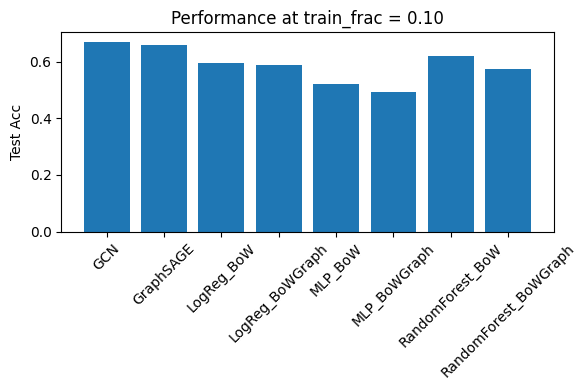

In [52]:
exp.plot_split(res_010, train_frac=0.10, metric="test_acc")

### b. Grid of train fractions

In [53]:
train_fracs = np.arange(0.10, 0.75, 0.10)
all_results = exp.run_grid(train_fracs, include_gnns=True)


=== Running single split with train_frac = 0.10 ===
GCN Epoch   1 | Loss 1.9403 | Train 0.167 | Val 0.349 | Test 0.363
GCN Epoch  50 | Loss 0.1377 | Train 0.974 | Val 0.635 | Test 0.676
GCN: early stopping at epoch 67
GraphSAGE Epoch   1 | Loss 2.4066 | Train 0.093 | Val 0.192 | Test 0.214
GraphSAGE Epoch  50 | Loss 0.0562 | Train 0.993 | Val 0.655 | Test 0.673
GraphSAGE: early stopping at epoch 65

=== Running single split with train_frac = 0.20 ===
GCN Epoch   1 | Loss 1.9496 | Train 0.152 | Val 0.388 | Test 0.383
GCN Epoch  50 | Loss 0.1894 | Train 0.972 | Val 0.688 | Test 0.694
GCN Epoch 100 | Loss 0.1716 | Train 0.967 | Val 0.695 | Test 0.696
GCN: early stopping at epoch 134
GraphSAGE Epoch   1 | Loss 2.4429 | Train 0.139 | Val 0.174 | Test 0.194
GraphSAGE Epoch  50 | Loss 0.0666 | Train 0.987 | Val 0.709 | Test 0.701
GraphSAGE: early stopping at epoch 86

=== Running single split with train_frac = 0.30 ===
GCN Epoch   1 | Loss 1.9889 | Train 0.138 | Val 0.445 | Test 0.454
GCN Ep

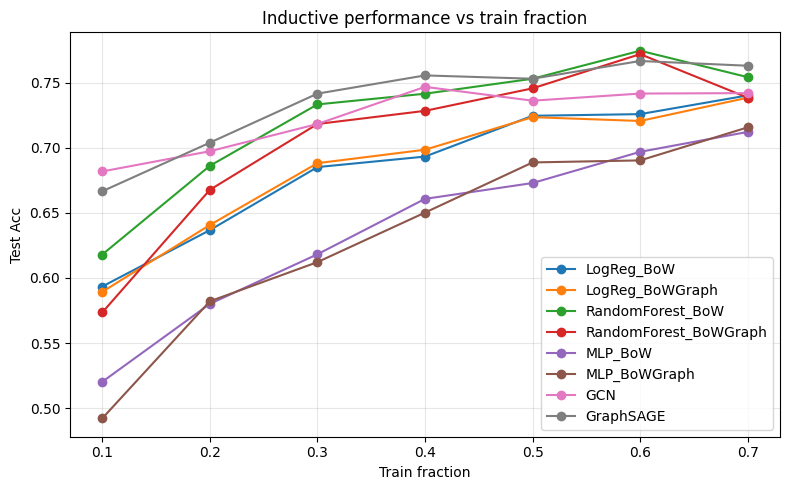

In [54]:
exp.plot_overall(all_results, metric="test_acc")

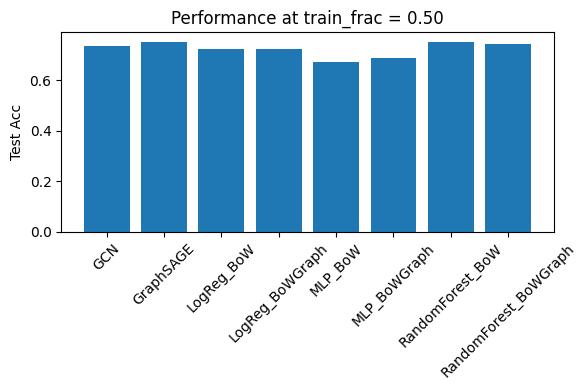

In [55]:
exp.plot_split(all_results, train_frac=0.50, metric="test_acc")